---
bibliography: ../references/references.bib
csl: ../references/abnt.csl
#tableEqns: true
---

# SINDy

Uma vez que os valores de uma grandeza qualquer sejam conhecidos para determinados instantes de tempo $t$, o método *Sparse Identification of Nonlinear Dynamic Systems (SINDy)* [@brunton2016] permite determinar, à partir dos dados os operadores $f$ que determinam a dinâmica do sistema, descrita por 

$$
\frac{d}{dt}x(t)=f(x(t))
$$ {#eq:1}

A principal hipótese por trás do método é que o sistema dinâmica é esparso no espaço de funções de base $f_i$ proposto, por exemplo, o sistema dinâmico descrito por

$$
\frac{d}{dt}x=f(t)=\begin{bmatrix} f_1(x) \\ f_2(x) \end{bmatrix} =
\begin{bmatrix} 1-x_1+3x_1x_2 \\ x_2^2-5x_1^3 \end{bmatrix}
$$

é esparso em um conjunto de funções de bases polinomiais de duas variáveis, uma vez que para funções de base $f_k=\sum_{i=0}^\infty\sum_{j=0}^\infty a_{i,j}x_1^ix_2^j$ um número pequeno de coeficientes $a_{i,j}$ serão diferentes de $0$.

O a dinâmica do sistema (@eq:1) pode ser representado de maneira aproximada por 

$$
\dot{X} \approx \Theta(X)\Xi
$$

Onde $X$ é a matrix de $snapshots$

$$
X = \begin{bmatrix}
x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
\vdots & \vdots & & \vdots \\
x_1(t_n) & x_2(t_n) & \dots & x_n(t_n) 
\end{bmatrix}
$$

A matrix $\Theta(X)$ é uma matrix de funções de base aplicadas aos dados $X$

$$
\Theta(X) = \begin{bmatrix}
\vert & \vert & \vert & \vert \\
\theta_1(X) & \theta_2(X) & \dots & \theta_l(X)  \\
\vert & \vert & \vert & \vert
\end{bmatrix}
$$

As formas das funções de bases são determinadas pela escolha das `function libraries`. A busca é belo conjunto de vetores de coeficientes esparsos $\xi_i$

$$
\Xi = \begin{bmatrix}
\vert & \vert & \vert& \vert\\
\xi_1 & \xi_2 & \dots & \xi_n\\
\vert & \vert& \vert& \vert\\
\end{bmatrix}
$$

# Exemplo de Utilização da Biblioteca

Os principais dados de entrada para o método SINDy são

- Os snapshots $X$
  - São fornecidos com uma matrix 
- As derivadas $\dot{X}$
  - Podem ser fornecidos no mesmo formato dos *snapshots* ou calculados com a função `psindy.differentiate`. As opções são:
    - `FiniteDifference`
    - `SINDyDerivative` wrapper para `dxdt` (`finite_difference, savitzky_golay, spectral, spline, trend_filtered, kalman`)
    - `SmoothedFiniteDifference`
    - `SpectralDerivative`
- As funções de base $\Theta$
  - São especificadas no objeto `pysindy.feature_library`:
    - 
- Otimizator
  - Especificado no objeto `pysindy.optimizer`
  

In [88]:
import numpy as np
import pysindy as ps

t = np.linspace(0,1,100)
x = 3 * np.exp(-2 * t)
y = 0.5 * np.exp(t)
X = np.stack((x,y), axis=1)

In [89]:
differentiation_method = ps.FiniteDifference(order=2)

In [90]:
feature_library = ps.PolynomialLibrary(degree=3)

In [91]:
optimizer = ps.STLSQ(threshold=0.2)

In [92]:
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)

In [93]:
model.fit(X, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=3), feature_names=['x', 'y'],
      optimizer=STLSQ(threshold=0.2))

In [94]:
model.print()

(x)' = -2.000 x
(y)' = 1.000 y


In [95]:
x0 = 6
y0 = -0.1

t_test = np.linspace(0, 1, 100)
x_test = x0 * np.exp(-2 * t_test)
y_test = y0 * np.exp(t_test)

sim = model.simulate([x0, y0], t=t_test)

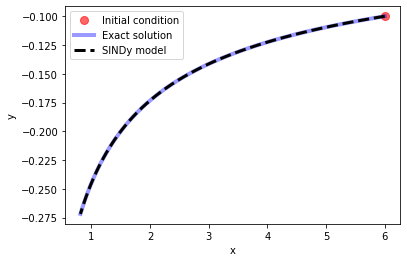

In [96]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x0, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(x_test, y_test, "b", label="Exact solution", alpha=0.4, linewidth=4)
plt.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [ ]:
sys.path.insert(0, '../')
import numpy as np
from twoPhaseFlow import twoPhaseFlow as tpf
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.io import loadmat

In [ ]:
N = 100
x = np.linspace(0,1,N)
Nt = 100
t = np.linspace(0,1,Nt)
M = 1

u = tpf.u_solve(tpf.u_convex, x, t, M)

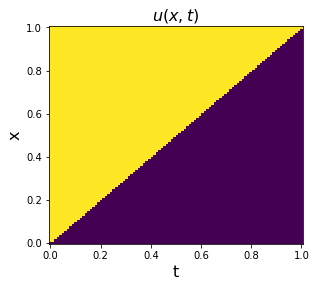

In [ ]:
# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)

u = u.reshape(len(x), len(t), 1)


In [ ]:
library_functions = [lambda x: x, lambda x: x*x]
library_functions_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions = library_functions,
    function_names = library_functions_names,
    derivative_order = 1,
    spatial_grid = x, 
    is_uniform=True
)
pde_opt = ps.STLSQ(threshold=30, normalize_columns=True)

model = ps.SINDy(
    optimizer=pde_opt,
    feature_library=pde_lib,
    feature_names=['u']
)
dt = t[1]-t[0]
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, feature_names=['u'], optimizer=optimizer)
model.fit(u, t=dt)
model.print()



SSR model: 
(u)' = 0.125 u + -0.350 uu + -0.259 u_1 + -0.010 uu_1 + -0.640 uuu_1
